In [11]:
# !pip install keras
# !pip install tensorflow
# !pip install layer

In [12]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from scipy import signal

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def preprocess_data(x, y, limit):
    zero_index = np.where(y==0)[0][:limit]
    one_index = np.where(y==1)[0][:limit]
    all_indices = np.hstack((zero_index,one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    y = to_categorical(y)
    y = y.reshape(len(y), 2, 1)
    return x, y
    

In [14]:
pip install pandas

In [10]:
import pandas as pd

data =  mnist.load_data()
train = pd.read_csv('mnist_train.csv')
test = pd.read_csv('mnist_train.csv')
y_train = train['label']
x_train = train.drop('label', axis=1)

x_train, y_train = preprocess_data(x_train, y_train, 100)

FileNotFoundError: [Errno 2] No such file or directory: 'mnist_train'

In [5]:
class Convolutional():
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape) 

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                # self.output[i] += np.dot(self.input[j], self.kernels[i][j])
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")

        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)
        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")
        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient
    

In [6]:
class Activation():
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [7]:
class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class Softmax():
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)
        # Original formula:
        # tmp = np.tile(self.output, n)
        # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

In [8]:
class Reshape():
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
    def forward(self, input):
        return np.reshape(input, self.output_shape)
    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)
        

In [9]:
class Dense():
    def __init__(self, input_size, output_size):
        self.Kernels = np.random.randn(output_size, input_size)
        self.Bias = np.random.randn(output_size, 1)
    
    def forward(self, input):
        self.input = input
        return np.dot(self.Kernels, self.input) + self.Bias

    def backward(self, output_gradient, learning_rate):
        Kernels_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.Kernels.T, output_gradient)
        self.Kernels -= learning_rate * Kernels_gradient
        self.Bias -= learning_rate * output_gradient
        return input_gradient
        

In [10]:
import numpy as np

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [11]:
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid()
]

In [12]:
num_epochs = 10
learning_rate = 0.1
losses = []

for e in range(num_epochs):
    error = 0
    for x, y in zip(x_train, y_train):
        output = x
        for layer in network:
            output = layer.forward(output)

        error += binary_cross_entropy(y, output)

        grad = binary_cross_entropy_prime(y, output)
        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)

    error /= len(x_train)
    losses.append(error)
    print(f"{e + 1}/{num_epochs}, error={error}")   


1/10, error=0.47381930898147784
2/10, error=0.13663781838837036
3/10, error=0.09626969743996092
4/10, error=0.048844403457262056
5/10, error=0.044251367879366656
6/10, error=0.02232727577823192
7/10, error=0.024179243108009913
8/10, error=0.010529444062901001
9/10, error=0.007395357677784859
10/10, error=0.006187802784813949


Text(0.5, 0, 'epoch')

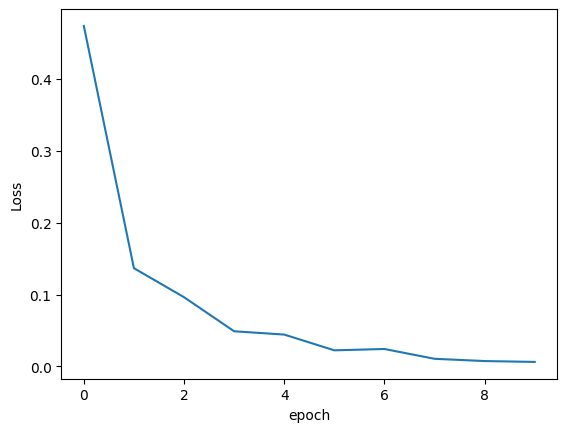

In [13]:
plt.plot(range(num_epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch')

In [14]:
wrongs = 0
y_output = []
for x, y in zip(x_test, y_test):
    output = x
    for layer in network:
        output = layer.forward(output)
    print(f"pred: {np.argmax(output)}, desired: {np.argmax(y)}")
    y_output.append(np.argmax(output))
    if np.argmax(output) != np.argmax(y):
        wrongs += 1

print("Wrongs: ",wrongs)

pred: 1, desired: 1
pred: 0, desired: 0
pred: 0, desired: 0
pred: 0, desired: 0
pred: 1, desired: 1
pred: 0, desired: 0
pred: 0, desired: 0
pred: 0, desired: 0
pred: 1, desired: 1
pred: 0, desired: 0
pred: 0, desired: 0
pred: 1, desired: 1
pred: 1, desired: 1
pred: 0, desired: 0
pred: 1, desired: 1
pred: 0, desired: 0
pred: 1, desired: 1
pred: 1, desired: 1
pred: 0, desired: 0
pred: 0, desired: 0
pred: 1, desired: 1
pred: 1, desired: 1
pred: 1, desired: 1
pred: 1, desired: 1
pred: 0, desired: 0
pred: 0, desired: 0
pred: 1, desired: 1
pred: 1, desired: 1
pred: 0, desired: 0
pred: 1, desired: 1
pred: 0, desired: 0
pred: 1, desired: 1
pred: 1, desired: 1
pred: 1, desired: 1
pred: 1, desired: 1
pred: 0, desired: 0
pred: 1, desired: 1
pred: 1, desired: 1
pred: 0, desired: 0
pred: 0, desired: 0
pred: 0, desired: 0
pred: 1, desired: 1
pred: 0, desired: 0
pred: 1, desired: 1
pred: 1, desired: 1
pred: 0, desired: 0
pred: 1, desired: 1
pred: 1, desired: 1
pred: 1, desired: 1
pred: 0, desired: 0


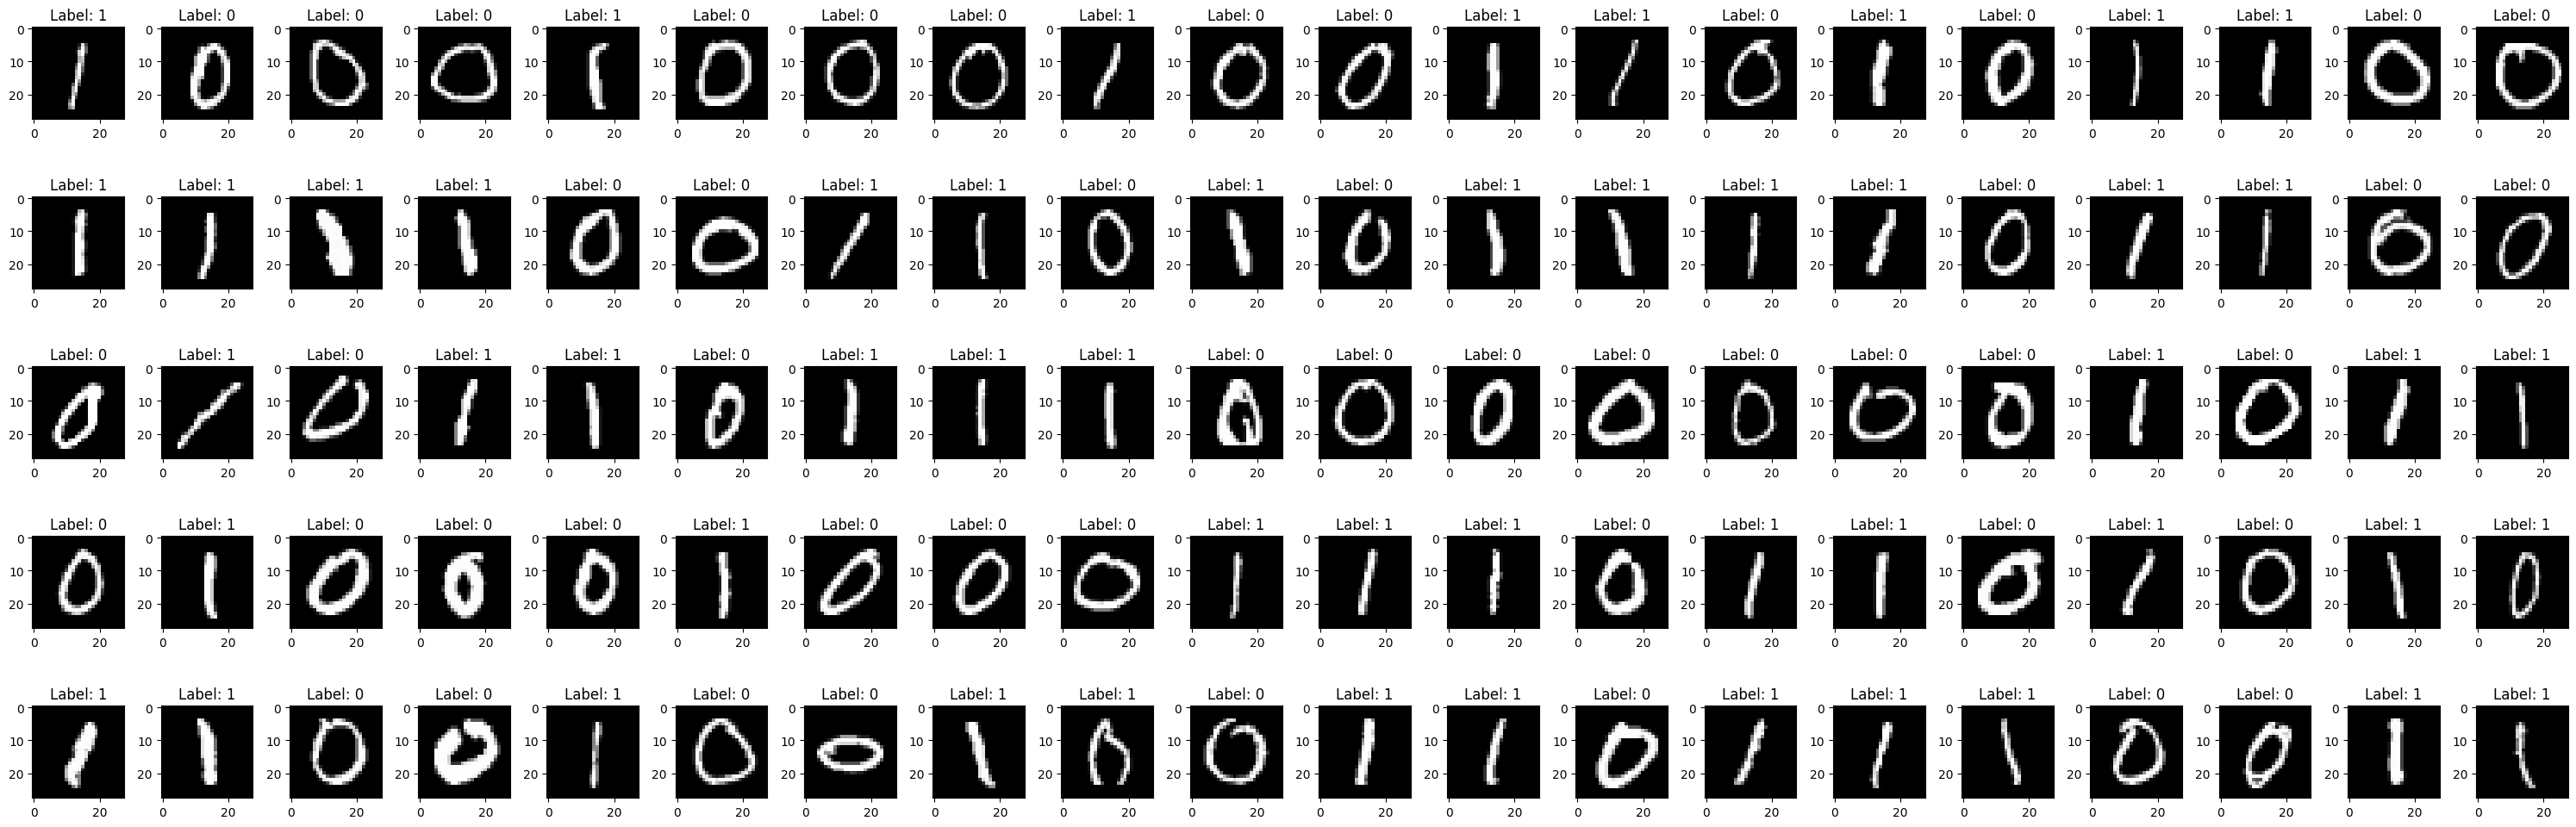

In [15]:
num = 100
X_test = x_test.reshape(x_test.shape[0], 28, 28)
images = X_test[:num]
labels = y_output[:num]
num_row = 5
num_col = 20

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()